In [5]:
%pip install networkx

In [6]:
%pip install psycopg2-binary


Note: you may need to restart the kernel to use updated packages.


In [7]:
%pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


In [8]:
%pip install pandas

Note: you may need to restart the kernel to use updated packages.


In [8]:
import networkx as nx

In [9]:
import matplotlib.pyplot as plt

In [10]:
import psycopg2

In [11]:
import pandas as pd

In [12]:
DB_NAME = 'mapData'
DB_USER = 'postgres'
DB_PASSWORD = '1234'
DB_HOST = 'localhost'

In [13]:
# Establish a connection to the database
conn = psycopg2.connect(dbname=DB_NAME, user=DB_USER, password=DB_PASSWORD, host=DB_HOST)

In [14]:
# Create a cursor object to execute SQL queries
cur = conn.cursor()

In [15]:
# Fetch data from table
cur.execute('SELECT * FROM edges_lrt_mrt')
rows = cur.fetchall()

In [16]:
# Fetch crowd_status data from table merged_mrt_lrt
cur.execute('SELECT * FROM merged_mrt_lrt')
rows_crowd = cur.fetchall()

In [20]:

# Convert the fetched data into a pandas DataFrame
columns = ['id', 'line', 'station_name', 'latitude', 'longitude', 'crowd_status', 'availibility_status', 'order_index']
df = pd.DataFrame(rows_crowd, columns=columns)

# Select only the 'column1' and 'column2' columns
df_selected = df[['id', 'crowd_status']]

# Display the DataFrame
print(df_selected)


     id   crowd_status
0     3       Not busy
1     4   Not too busy
2     5       Not busy
3     8       Not busy
4     9       Not busy
..   ..            ...
155  95       Not busy
156  96  Not Available
157  97       Not busy
158  98  Not Available
159  99       Not busy

[160 rows x 2 columns]


In [26]:
# Convert the fetched data into a pandas DataFrame for easier manipulation
columns = ['id','source_station_id', 'destination_station_id', 'distance']
df = pd.DataFrame(rows, columns=columns)

In [18]:
cur.close()
conn.close()

In [19]:
# Display the fetched data
print(df)

      id  source_station_id  destination_station_id  distance
0    309                  1                       2         3
1    310                  2                       3         2
2    311                  3                       4         3
3    312                  4                       5         3
4    313                  5                       6         3
..   ...                ...                     ...       ...
179  488                 84                      47         1
180  489                  5                     160        10
181  490                  9                     155         2
182  491                155                      27         2
183  492                  9                      27         0

[184 rows x 4 columns]


In [20]:
import networkx as nx

In [23]:
# Create an empty graph
G = nx.Graph()

In [39]:
# Add edges representing connections between stations
for index, row in df.iterrows():
    G.add_edge(row['source_station_id'], row['destination_station_id'], weight=row['distance'])


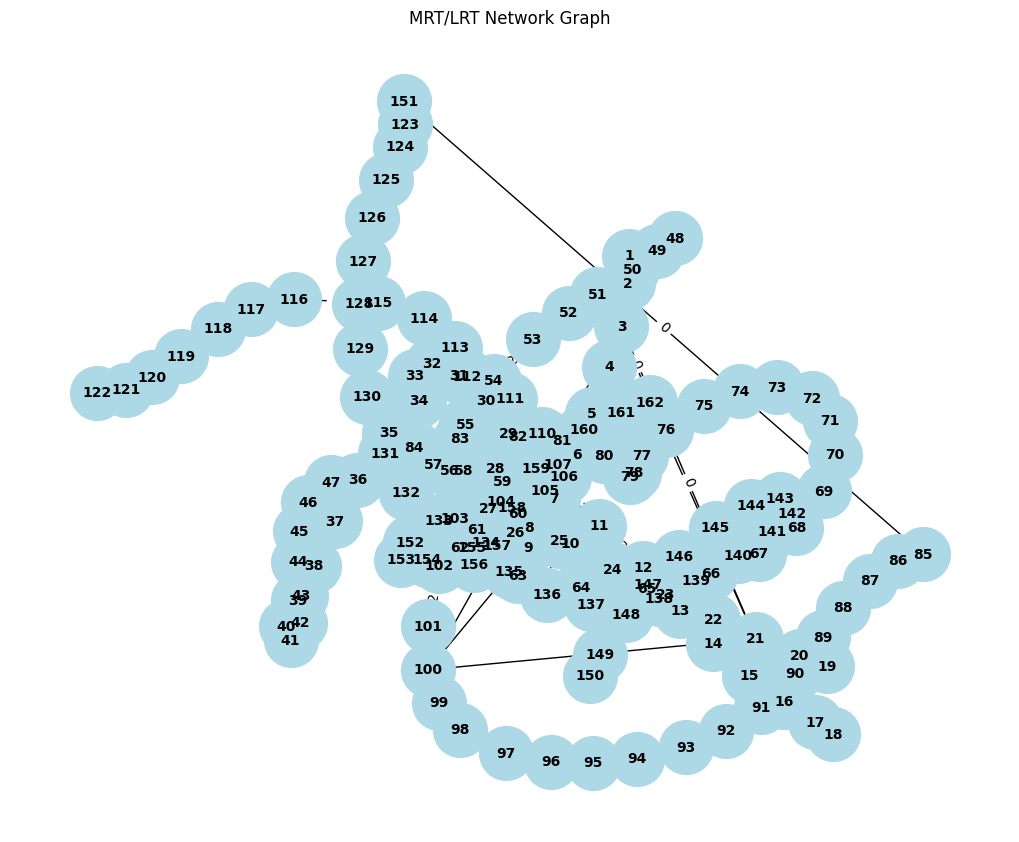

In [40]:
# Draw the graph
plt.figure(figsize=(10, 8))
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_size=1500, node_color='lightblue', font_size=10, font_weight='bold', arrows=True)
edge_labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
plt.title('MRT/LRT Network Graph')
plt.show()

In [98]:
import heapq
import math

def astar_shortest_path(G, source_station_id, destination_station_id, avoid_crowd=False):
    path = None
    def heuristic_distance(source_station_id, destination_station_id):
        source_x, source_y = pos[source_station_id]
        destination_x, destination_y = pos[destination_station_id]
        distance = abs(destination_x - source_x) + abs(destination_y - source_y)
        return distance
    
    # Define the priority queue for the open set
    open_set = [(0, source_station_id)]
    # Define the set of visited stations
    visited = set()
    # Define the dictionary to store the actual distance from the start station to each station
    g_score = {source_station_id: 0}
    # Define the dictionary to store the estimated total distance from the start station to each station
    f_score = {source_station_id: heuristic_distance(source_station_id, destination_station_id)}
    # Define the dictionary to store the previous station in the shortest path
    came_from = {}
    
    while open_set:
        # Get the station with the lowest f_score
        _, current_station = heapq.heappop(open_set)
        
        if current_station == destination_station_id:
            # Reconstruct the path from the end station to the start station
            path = [current_station]
            while current_station != source_station_id:
                current_station = came_from[current_station]
                path.append(current_station)
            path.reverse()
            return path
        
        # Add the current station to the visited set
        visited.add(current_station)
        
        # Explore the neighbors of the current station
        for neighbor in G.neighbors(current_station):
            if neighbor in visited:
                continue

            # Ignore the avoidance if the neighbor is the destination station or start station
            if avoid_crowd and neighbor in [source_station_id, destination_station_id]:
                continue
            
            # Check if the neighbor station is busy and should be avoided
            if avoid_crowd and neighbor in df_selected[df_selected['crowd_status'].isin(['Busy', 'Busier than usual'])]['id'].values:
                continue

            # Calculate the tentative g_score for the neighbor
            tentative_g_score = g_score[current_station] + G[current_station][neighbor]['weight']
            
            if neighbor not in g_score or tentative_g_score < g_score[neighbor]:
                # Update the g_score and f_score for the neighbor
                g_score[neighbor] = tentative_g_score
                f_score[neighbor] = g_score[neighbor] + heuristic_distance(neighbor, destination_station_id)
                # Update the came_from dictionary
                came_from[neighbor] = current_station
                # Add the neighbor to the open set
                heapq.heappush(open_set, (f_score[neighbor], neighbor))

    # If no path is found and avoid_crowd is True, try again without avoiding crowded stations
    if path is None and avoid_crowd:
        print("No path found avoiding crowded stations. Finding path without avoiding crowded stations...")
        return astar_shortest_path(G, source_station_id, destination_station_id, avoid_crowd=False)

    # If no path is found and avoid_crowd is False, return an empty list
    return path if path is not None else []




In [99]:
# Prompt the user for input
source_station_id = int(input("Enter the start station ID: "))
destination_station_id = int(input("Enter the end station ID: "))
avoid_crowd = input("Avoid crowded stations? (y/n): ").lower() == "y"

# Call the function with user input
path = astar_shortest_path(G, source_station_id, destination_station_id, avoid_crowd)

# Get the list of crowded stations
crowded_stations = df_selected[df_selected['crowd_status'].isin(['Busy', 'Busier than usual'])]['id'].values

# Create a new path list with crowd status for crowded stations
path_with_crowd_status = []
for station in path:
    if station in crowded_stations:
        crowd_status = df_selected[df_selected['id'] == station]['crowd_status'].values[0]
        path_with_crowd_status.append(f"{station} ({crowd_status})")
    else:
        path_with_crowd_status.append(str(station))

print("Shortest path:", path_with_crowd_status)


No path found avoiding crowded stations. Finding path without avoiding crowded stations...
Shortest path: ['1', '2', '3', '100', '101', '102', '103', '56', '55', '54 (Busier than usual)', '53', '52 (Busier than usual)']
